In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2\notebooks\Support Notebooks for Modules
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [2]:
import numpy as np
from sklearn import metrics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from modules.lib.ChextXRayImages import *
from modules.lib.Metrics import *
from modules.lib.TrainingLoop import *
from modules.models.CustomPneumonia import CustomPneumoniaNN

from PIL import Image
import copy

import torch.optim as optim
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.models as models

from torchsummary import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib inline

In [3]:
force_cpu = True
device = torch.device('cuda' if ~force_cpu and torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


In [4]:
loaders = Loaders()
batch_size=16
val_percent=0.15
number_images = 20000
train_loader, val_loader = loaders.getDataTrainValidateLoaders(batch_size=batch_size, 
                                                                        val_percent=val_percent, 
                                                                        n_random_rows=number_images)

target_columns = loaders.target_columns

train_actual = loaders.train_df
val_actual = loaders.val_df

print(f'Number of Training Batches: {len(train_loader):,}')
print(f'Number of Validation Batches: {len(val_loader):,}')
print(f'Number of Training Images: {len(train_loader) * batch_size:,}')
print(f'Number of Validation Images: {len(val_loader) * batch_size:,}')

Number of Training Batches: 1,069
Number of Validation Batches: 182
Number of Training Images: 17,104
Number of Validation Images: 2,912


In [5]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)       
        self.flattened_length_ = 1*320*320
        self.fc1 = nn.Linear(self.flattened_length_, 12)
       
    def forward(self, x):    
        x = x.view(-1, self.flattened_length_)    
        x = self.fc1(x)
        return x

In [6]:
net = SimpleModel()

net = nn.DataParallel(net)
net.to(device)

summary(net, (1, 320, 320)) #Known Harded code size generated by data loaders (todo: make attribute of loaders)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]       1,228,812
       SimpleModel-2                   [-1, 12]               0
Total params: 1,228,812
Trainable params: 1,228,812
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.39
Forward/backward pass size (MB): 0.00
Params size (MB): 4.69
Estimated Total Size (MB): 5.08
----------------------------------------------------------------


In [7]:
learning_rate = 1e-4
num_epochs = 2

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.9)

metrics = Metrics(target_columns, train_actual, val_actual, cc=0)
trainingLoop = TrainingLoop(device, net, optimizer, criterion, metrics)

In [8]:
help(Metrics.displayMetrics)

Help on function displayMetrics in module modules.lib.Metrics:

displayMetrics(self, metricDataSource=<MetricDataSource.Both: 0>, showCombinedMetrics=True, showMetricDataFrame=True, showROCCurves=True, showPrecisionRecallCurves=True, include_targets=None, combinedAverageMethod='samples', gridSpecColumnCount=4, gridSpecHeight=3, gridSpecWidth=20)
    docstring



In [9]:
trainingLoop.epoch_metric_display_args = (0, True, False, False, False,  ['Edema', 'Lung_Opacity', 'Pneumonia'])

In [10]:
trainingLoop.train(num_epochs, train_loader, val_loader)

Epoch [1/2]
Epoch Loss: 902.3341         
Training Time: 0:02:34.851061)          
Validation Time: 0:00:29.322869)

TRAINING



,Score for all Targets
Accuracy Score,0.066869
Hamming Loss,0.193315
Combined Recall,0.211367
Combined Precision,0.228576
Combined F1,0.197721



VALIDATION



,Score for all Targets
Accuracy Score,0.012040
Hamming Loss,0.345545
Combined Recall,0.256330
Combined Precision,0.132170
Combined F1,0.158742


Epoch [2/2]
Epoch Loss: 881.9023         
Training Time: 0:03:36.038489)          
Validation Time: 0:00:32.240815)

TRAINING



,Score for all Targets
Accuracy Score,0.068157
Hamming Loss,0.191843
Combined Recall,0.212269
Combined Precision,0.229360
Combined F1,0.198197



VALIDATION



,Score for all Targets
Accuracy Score,0.016168
Hamming Loss,0.301944
Combined Recall,0.485460
Combined Precision,0.259460
Combined F1,0.310849



TRAINING



,Score for all Targets
Accuracy Score,0.068157
Hamming Loss,0.191843
Combined Recall,0.212269
Combined Precision,0.229360
Combined F1,0.198197


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,879,0.053470,0.061278,0.057108,0.509152,0.053372
1,Cardiomegaly,1917,0.098592,0.112836,0.105234,0.496734,0.111061
2,Lung_Opacity,7858,0.462586,0.465131,0.463855,0.503526,0.459254
3,Lung_Lesion,713,0.044881,0.052545,0.048411,0.493448,0.042299
4,Edema,4094,0.216170,0.233879,0.224676,0.500563,0.238858
5,Consolidation,1014,0.044379,0.054348,0.048860,0.500180,0.059439
6,Pneumonia,475,0.016842,0.019560,0.018100,0.512993,0.028185
7,Atelectasis,2737,0.142126,0.162151,0.151480,0.500417,0.159938
8,Pneumothorax,1375,0.064000,0.075407,0.069237,0.507496,0.081479
9,Pleural_Effusion,5850,0.327179,0.338402,0.332696,0.496220,0.340721


***** ROC *****


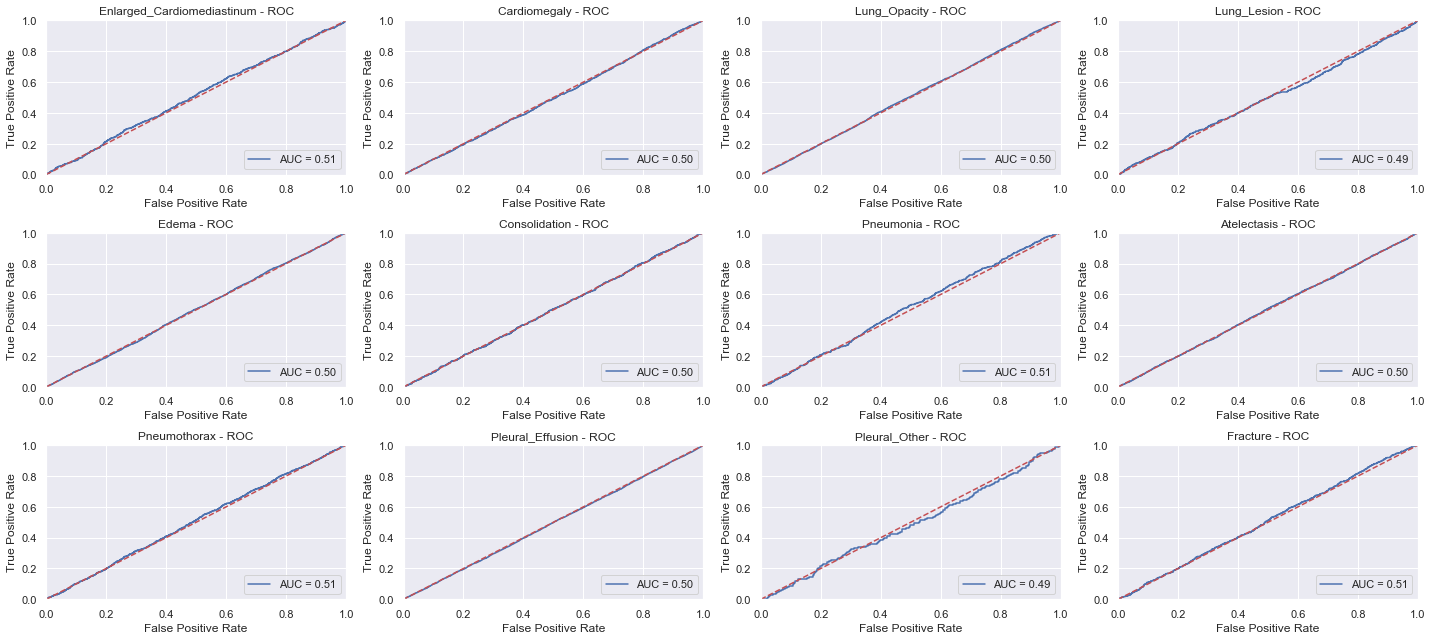

***** Precision / Recall *****


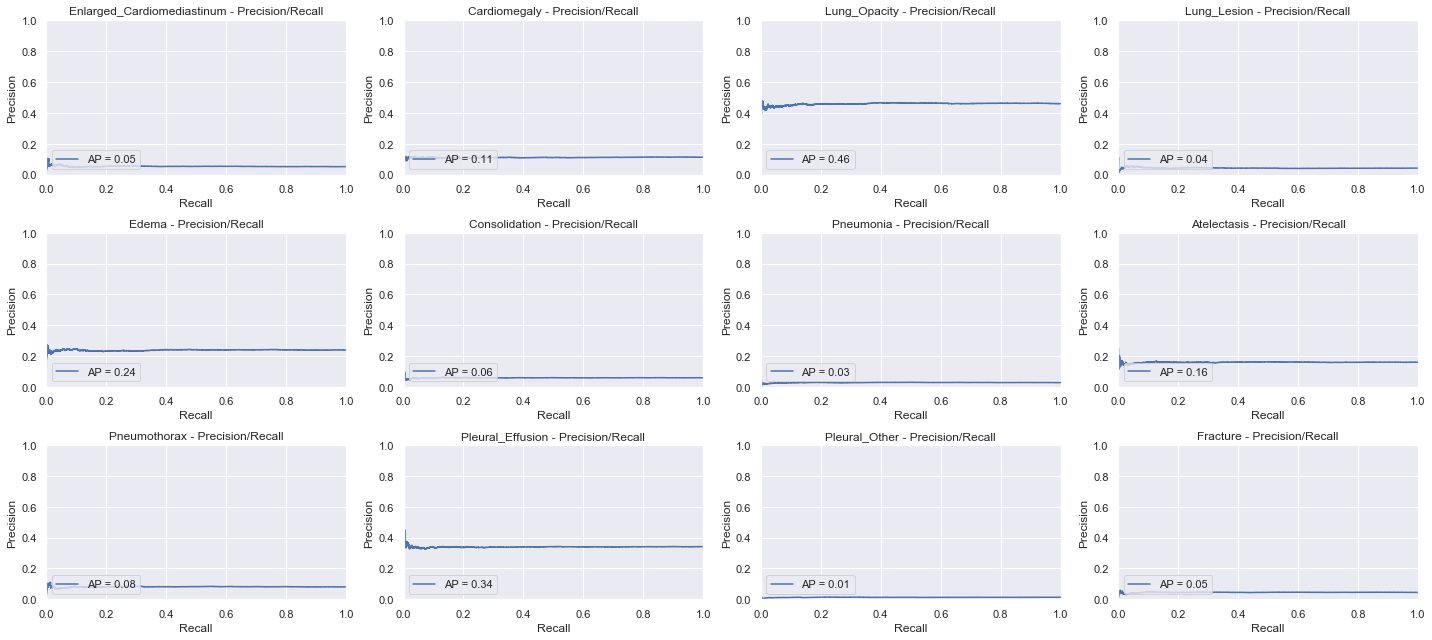


VALIDATION



,Score for all Targets
Accuracy Score,0.016168
Hamming Loss,0.301944
Combined Recall,0.485460
Combined Precision,0.259460
Combined F1,0.310849


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,153,0.013072,0.105263,0.023256,0.550512,0.068450
1,Cardiomegaly,318,0.254717,0.149723,0.188591,0.591523,0.135791
2,Lung_Opacity,1298,0.894453,0.454581,0.602804,0.544968,0.480849
3,Lung_Lesion,132,0.340909,0.055419,0.095339,0.528706,0.051844
4,Edema,661,0.308623,0.254047,0.278689,0.556078,0.264515
5,Consolidation,161,0.043478,0.048951,0.046053,0.526016,0.060106
6,Pneumonia,73,0.520548,0.025693,0.048969,0.520794,0.027973
7,Atelectasis,456,0.682018,0.161979,0.261785,0.503278,0.152886
8,Pneumothorax,229,0.122271,0.069307,0.088468,0.462186,0.071076
9,Pleural_Effusion,975,0.947692,0.349338,0.510497,0.601748,0.405391


***** ROC *****


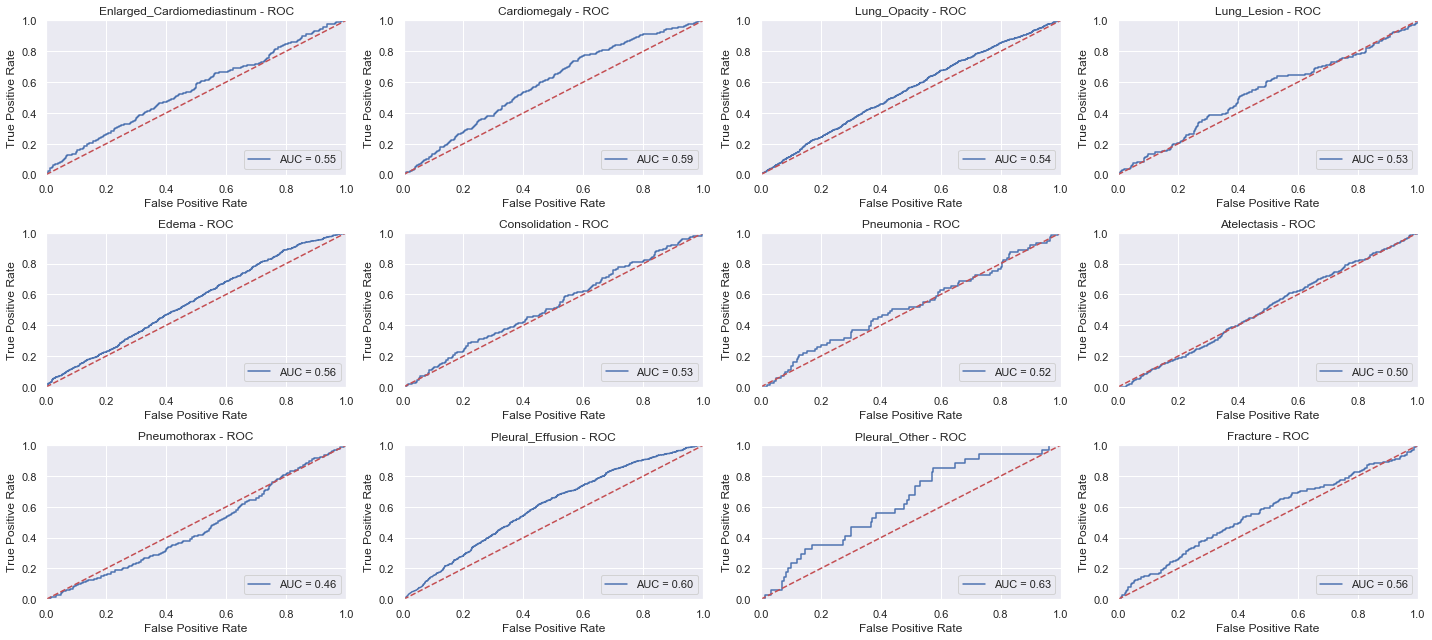

***** Precision / Recall *****


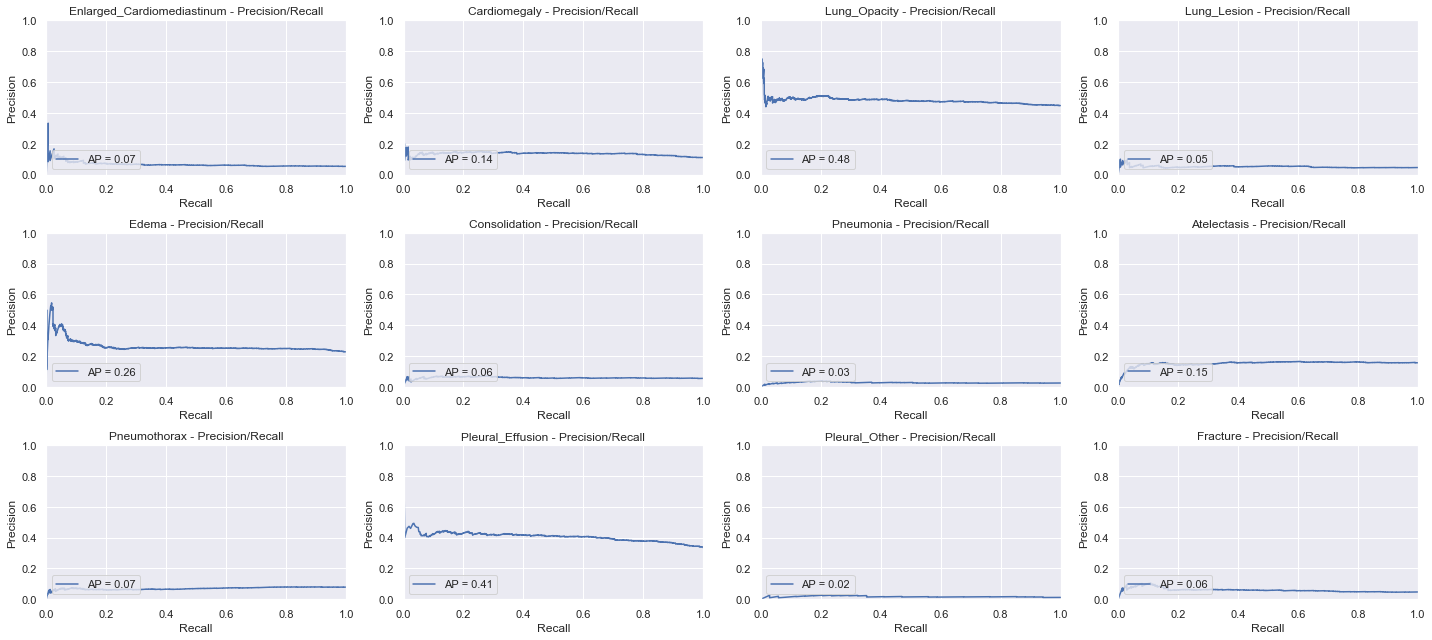

In [11]:
metrics.displayMetrics()

## Results

Since the model was not expected to do better than a 50/50 chance, the final metric output looks good.

One of the best indicators of the 50/50 model is the ROC curves.  For training, all the curves are on the diagonal.

Also, the P/R curves do not look like P/R curves.  In fact, the Average Precision approximates the ground truth positive percentages.